### Import

In [103]:
import pandas as pd
import talib 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [82]:
df = pd.read_csv("./data/stocks/AAPL.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


### TA indicators

In [83]:
df['SMA_10'] = talib.SMA(df['Close'], timeperiod=10)
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
df["Upper_BB"], df["Middle_BB"], df["Lower_BB"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_20,EMA_20,RSI_14,Upper_BB,Middle_BB,Lower_BB,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
#df.fillna(method='ffill', inplace=True)  
#df.dropna(inplace=True)
data = df['Close'].values.reshape(-1, 1)
#features = ['Close', 'EMA_12', 'EMA_26']
#data = df[features].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#features = ['Close', 'EMA_12', 'EMA_26', 'MACD', 'RSI_14']
#scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(len(features))]
#scaled_data = np.column_stack([scalers[i].fit_transform(df[features[i]].values.reshape(-1, 1)) for i in range(len(features))])

if np.any(np.isnan(scaled_data)):
    scaled_data = np.nan_to_num(scaled_data, nan=0.0)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(df['Close'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

#np.random.seed(42)
#tf.random.set_seed(42)

In [96]:
model = Sequential([
    #LSTM(128, return_sequences=True),
    #Dropout(0.1),
    #Dense(64, activation="relu"),
    LSTM(128, return_sequences=False), #input_shape=(seq_length, len(features))), #input_shape=(seq_length, 1)),
    Dropout(0.1),
    #Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', 
                        patience=10, 
                        restore_best_weights=True)

In [97]:
model.fit(X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size =32,
        shuffle = False,
        callbacks=[early_stop])

Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 5.7252e-06 - mae: 0.0014 - val_loss: 0.0129 - val_mae: 0.0935
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.8240e-04 - mae: 0.0061 - val_loss: 0.0136 - val_mae: 0.0955
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.0673e-04 - mae: 0.0081 - val_loss: 0.0129 - val_mae: 0.0939
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.4983e-04 - mae: 0.0063 - val_loss: 0.0117 - val_mae: 0.0890
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.2333e-04 - mae: 0.0068 - val_loss: 0.0129 - val_mae: 0.0923
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.6356e-04 - mae: 0.0084 - val_loss: 0.0074 - val_mae: 0.0703
Epoch 7/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.3290e-04 - mae: 0.0117 - val_loss: 0.0123 - val_mae: 0.0902
Epoch 8/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.8490e-04 - mae: 0.0132 - val_loss: 0.0133 - val_mae: 0.0948
Epoch 9/

In [98]:
y_pred = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1))
if np.any(np.isnan(y_pred)) or np.any(np.isnan(y_test_actual)):
    print("Dự đoán hoặc giá thực tế chứa NaN. Điền bằng 0.")
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

rmse = root_mean_squared_error(y_test_actual, y_pred)
print(f'RMSE: {rmse}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 114.4819349678507


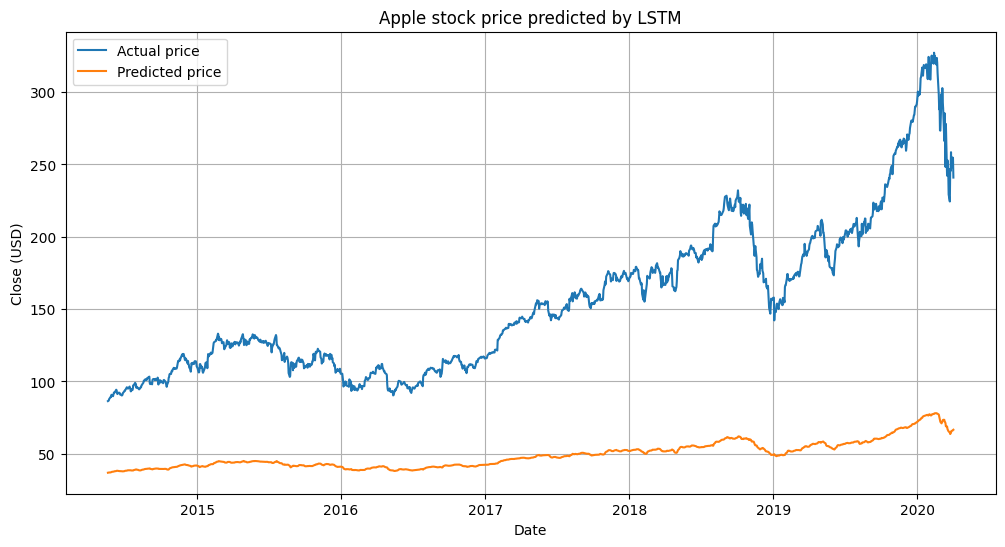

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual price')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted price')
plt.title('Apple stock price predicted by LSTM')
plt.xlabel('Date')
plt.ylabel('Close (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def process_stock(ticker, data_path="./data/stocks/{}.csv"):
    df = pd.read_csv(data_path.format(ticker), sep=',')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df.fillna(method='ffill', inplace=True)

    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
    df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    
    features = ['Close', 'Open', 'High', 'Low', 'RSI_14', 'EMA_12', 'EMA_26', 'MACD']
    data = df[features].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    if np.any(np.isnan(scaled_data)):
        scaled_data = np.nan_to_num(scaled_data, nan=0.0)

    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length][0])
        return np.array(X), np.array(y)
    
    seq_length = 60
    X, y = create_sequences(scaled_data, seq_length)

    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    #np.random.seed(42)
    #tf.random.set_seed(42)

    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(seq_length, len(features))),
        Dropout(0.1),
        #Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        #Dense(len(features))  
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='mse', 
                metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val), 
                        epochs=200, batch_size=32, 
                        shuffle=False, 
                        callbacks=[early_stop])
    
    y_pred = model.predict(X_test)
    #y_pred = scaler.inverse_transform(y_pred)
    #y_test_actual = scaler.inverse_transform(y_test)

    #if np.any(np.isnan(y_pred)) or np.any(np.isnan(y_test_actual)):
        #print(f"Dự đoán hoặc giá thực tế của {ticker} chứa NaN. Điền bằng 0.")
        #y_pred = np.nan_to_num(y_pred, nan=0.0)
        #y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

    close_scaler = MinMaxScaler()
    close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
    y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    #rmse_close = root_mean_squared_error(y_test_actual[:, 0], y_pred[:, 0])
    #rmse_ema12 = root_mean_squared_error(y_test_actual[:, 1], y_pred[:, 1])
    #rmse_ema26 = root_mean_squared_error(y_test_actual[:, 2], y_pred[:, 2])
    rmse_close = root_mean_squared_error(y_test_actual, y_pred_actual)
    print(f'RMSE for {ticker} - Close: {rmse_close:.4f}')
    mape_close = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    print(f'MAPE for {ticker} - Close: {mape_close:.4f}')

    #print(f'RMSE for {ticker} - EMA_12: {rmse_ema12}')
    #print(f'RMSE for {ticker} - EMA_26: {rmse_ema26}')
    
    plt.figure(figsize=(14, 5))
    plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Close Price')
    plt.plot(df.index[-len(y_pred):], y_pred_actual, label='Predicted Close Price')
    plt.title(f'Predict {ticker} - Close')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    '''plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 0], label='Actual Close Price')
    plt.plot(df.index[-len(y_pred):], y_pred[:, 0], label='Predicted Close Price')
    plt.title(f'Predict {ticker} - Close')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 1], label='Actual EMA_12')
    plt.plot(df.index[-len(y_pred):], y_pred[:, 1], label='Predicted EMA_12')
    plt.title(f'Predict {ticker} - EMA_12')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 2], label='Actual EMA_26')
    plt.plot(df.index[-len(y_pred):], y_pred[:, 2], label='Predict EMA_26')
    plt.title(f'Predict {ticker} - EMA_26')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()'''
    return [rmse_close], [mape_close], history

Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\1113917319.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 5.5903e-04 - mae: 0.0162 - val_loss: 0.0081 - val_mae: 0.0787
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0030 - mae: 0.0336 - val_loss: 0.0103 - val_mae: 0.0880
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0058 - mae: 0.0470 - val_loss: 0.0096 - val_mae: 0.0879
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0034 - mae: 0.0378 - val_loss: 0.0066 - val_mae: 0.0729
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0029 - mae: 0.0361 - val_loss: 0.0057 - val_mae: 0.0680
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0024 - mae: 0.0333 - val_loss: 0.0035 - val_mae: 0.0530
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0018 - mae: 0.0298 - val_loss: 0.0020 - val_mae: 0.0409
Epoch 8/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - mae: 0.0227 - val_loss: 0.0015 - val_mae: 0.0353
Epoch 9/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms

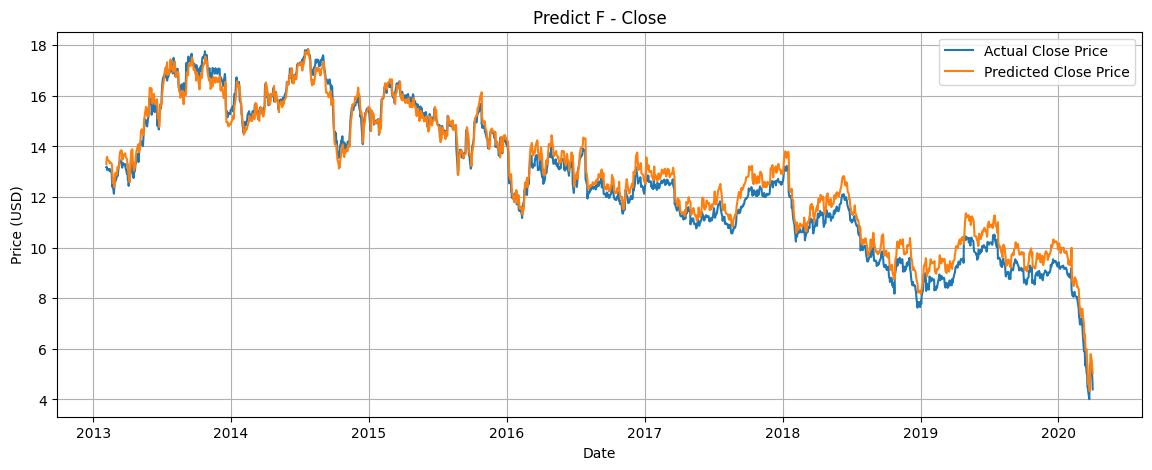

Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\1113917319.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 8.4497e-04 - mae: 0.0173 - val_loss: 0.0056 - val_mae: 0.0602
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.0164e-04 - mae: 0.0084 - val_loss: 0.0070 - val_mae: 0.0683
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.7121e-04 - mae: 0.0090 - val_loss: 0.0057 - val_mae: 0.0611
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.2196e-04 - mae: 0.0103 - val_loss: 0.0052 - val_mae: 0.0586
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.1545e-04 - mae: 0.0094 - val_loss: 0.0049 - val_mae: 0.0575
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.5561e-04 - mae: 0.0117 - val_loss: 0.0041 - val_mae: 0.0513
Epoch 7/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.8756e-04 - mae: 0.0134 - val_loss: 0.0015 - val_mae: 0.0328
Epoch 8/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8000e-04 - mae: 0.0102 - val_loss: 1.4972e-04 - val_mae: 0.0097
Epoch 9/200
216/

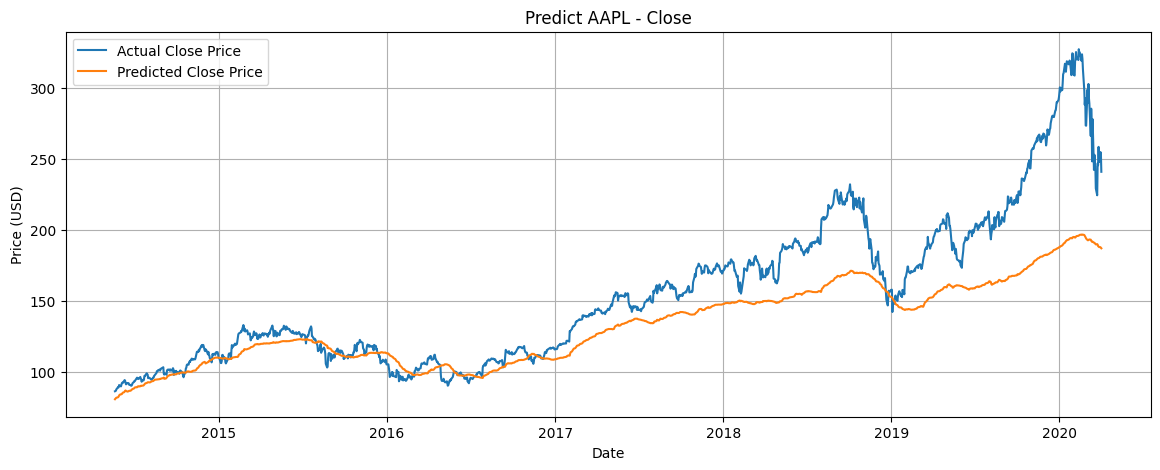

Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\1113917319.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0028 - mae: 0.0358 - val_loss: 0.0089 - val_mae: 0.0930
Epoch 2/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0020 - mae: 0.0326 - val_loss: 7.2435e-04 - val_mae: 0.0247
Epoch 3/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.2466e-04 - mae: 0.0170 - val_loss: 3.3264e-04 - val_mae: 0.0170
Epoch 4/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.5925e-04 - mae: 0.0117 - val_loss: 2.1407e-04 - val_mae: 0.0136
Epoch 5/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7909e-04 - mae: 0.0095 - val_loss: 5.9357e-05 - val_mae: 0.0063
Epoch 6/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2336e-04 - mae: 0.0077 - val_loss: 5.1313e-05 - val_mae: 0.0059
Epoch 7/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0738e-04 - mae: 0.0070 - val_loss: 5.2612e-05 - val_mae: 0.0058
Epoch 8/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0598e-04 - mae: 0.0071 - val_loss: 3.8991e-05 - val_mae: 0.0049


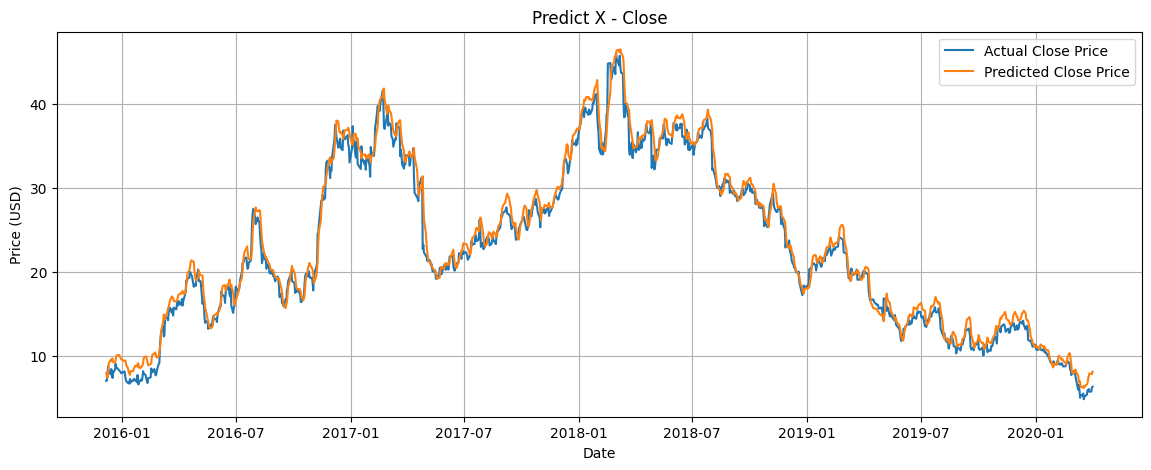

In [111]:
tickers = ['F', 'AAPL', 'X']
results = {}

for ticker in tickers:
    rmse, mape, history = process_stock(ticker)
    results[ticker] = {'rmse': rmse, 'mape': mape}